# 社群媒體分析 Final Project - 第一組
### 專案主題 : 電動車相關之分析
M114020022 高雲揚、M114020038 李畇彤、M114020052 王渙鈞、M114020060 陳侑萱

### 大綱
1. 動機與分析目的
2. 分析方向及工具
3. 基本資料介紹
4. 資料前處理
    - 留言萃取
    - 斷詞
5. LDA 主題模型
    - 模型建立
    - Pyvis視覺化
6. 主題情緒分析
    - SnowNLP 情緒分析
    - 針對5個主題進行分析
7. 結論

## 1. 動機與分析目的

因為日前特斯拉降價造成全球的轟動，全球討論電動車的聲浪與日俱增，因此我們想探討看看電動車相關的一些輿情分析，以及輿論的主題大致上可以分成哪幾類

## 2. 分析方向及工具

### 分析方向
- 主題模型，用來分析輿論主題的類別．
- 情緒分析，用以分析輿論的情緒．

## 3. 基本資料介紹

- 資料來源：文字平台 PTT car(車)、CarShop(汽車買賣)
- 資料集：tesla_ptt.csv
- 關鍵字：特斯拉、降價、tesla、馬斯克、電動車
- 資料時間：2022-05-01 ～ 2023-05-31
- 資料量： 2312 篇文章

## 4. 資料前處理

套件設定

In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint
from snownlp import SnowNLP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
from matplotlib import font_manager
font_set = {f.name for f in font_manager.fontManager.ttflist}
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False

載入資料

In [4]:
ptt = pd.read_csv("./rawData/tesla_ptt.csv") 
ptt.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/car/M.1651362925.A.227....,[心得]Mustang2.3T入手心得,2022-05-01 07:55:23,t9300092,car,每個人心中都有一台屬於自己的本命車\r\n而我的本命車就是野馬\r\n雖然這台車\r\n\r...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""twfi75"", ""cm...",114.26.200.41,2022-05-02 01:05:04,ptt
1,2,https://www.ptt.cc/bbs/car/M.1651380384.A.4D8....,[新聞]涉嫌排放數據造假！歐洲SuzukiVitara、,2022-05-01 12:46:20,TaiwanNeko,car,原文連結：\r\nhttps://auto.ltn.com.tw/news/20188/3\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""OrzOGC"", ""cm...",36.230.172.76,2022-05-02 01:05:06,ptt
2,3,https://www.ptt.cc/bbs/car/M.1651381465.A.3B6....,[新聞]BMW全新方向盤曝光酷似特斯拉矩形方向,2022-05-01 13:04:23,blue1011,car,原文連結：\r\nhttps://reurl.cc/p1xlzZ\r\n原文內容：\r\n\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""OrzOGC"", ""cm...",49.216.187.139,2022-05-02 01:05:06,ptt


看看有幾篇文章

In [5]:
print(f"number of posts: {ptt.shape[0]}")
print(f"date range: {(ptt['artDate'].min(), ptt['artDate'].max())}")
print(f"category: \n{ptt['artCatagory'].value_counts()}")


number of posts: 2312
date range: ('2022-05-01 07:55:23', '2023-05-30 22:48:03')
category: 
artCatagory
car        1954
CarShop     358
Name: count, dtype: int64


### 留言萃取
取出`artComment`的`cmtContent`

In [6]:
ptt = ptt[ptt.artComment != '[]'] # 刪除沒有comment的文章

# 取出 commentContent
def getComtInfo(com):
    cmtContent = ""
    com = eval(com)
    # print(com)
    for i in com:
        # print(i)
        cmtContent += i['cmtContent']
    return pd.Series([cmtContent])


ptt[['cmtContent']] = ptt['artComment'].apply(lambda r: getComtInfo(r))
ptt.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,cmtContent
0,1,https://www.ptt.cc/bbs/car/M.1651362925.A.227....,[心得]Mustang2.3T入手心得,2022-05-01 07:55:23,t9300092,car,每個人心中都有一台屬於自己的本命車\r\n而我的本命車就是野馬\r\n雖然這台車\r\n\r...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""twfi75"", ""cm...",114.26.200.41,2022-05-02 01:05:04,ptt,:帥:奇怪，同一顆引擎，FocusST油耗只有8km/l:帥野馬開帥就好:超帥！:白野馬也是...
1,2,https://www.ptt.cc/bbs/car/M.1651380384.A.4D8....,[新聞]涉嫌排放數據造假！歐洲SuzukiVitara、,2022-05-01 12:46:20,TaiwanNeko,car,原文連結：\r\nhttps://auto.ltn.com.tw/news/20188/3\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""OrzOGC"", ""cm...",36.230.172.76,2022-05-02 01:05:06,ptt,":柴油車吧,油車還早:柴油車可憐哪:想到當年在戰汽油柴油就覺得好笑:韓國車會是下一個嗎:靠北..."
2,3,https://www.ptt.cc/bbs/car/M.1651381465.A.3B6....,[新聞]BMW全新方向盤曝光酷似特斯拉矩形方向,2022-05-01 13:04:23,blue1011,car,原文連結：\r\nhttps://reurl.cc/p1xlzZ\r\n原文內容：\r\n\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""OrzOGC"", ""cm...",49.216.187.139,2022-05-02 01:05:06,ptt,:這不是抄伙計的嗎?:建議配一隻XBOX手把最好，還可以無線操控:先知總是孤獨的，大部分人只...


清除網址及留下中文字

In [7]:
ptt["artContent"] = ptt["artContent"].str.replace("(http|https)://.*", "", regex=True)
ptt["artContent"] = ptt["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ptt["artTitle"] = ptt["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ptt["artTitle"] = ptt["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ptt["cmtContent"] = ptt["cmtContent"].str.replace("(http|https)://.*", "", regex=True)
ptt["cmtContent"] = ptt["cmtContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ptt.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,cmtContent
0,1,https://www.ptt.cc/bbs/car/M.1651362925.A.227....,心得入手心得,2022-05-01 07:55:23,t9300092,car,每個人心中都有一台屬於自己的本命車而我的本命車就是野馬雖然這台車操控很美式很差的意思停車不方...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""twfi75"", ""cm...",114.26.200.41,2022-05-02 01:05:04,ptt,帥奇怪同一顆引擎油耗只有帥野馬開帥就好超帥白野馬也是我的夢想車無奈現實還是跟低頭不過下一台一...
1,2,https://www.ptt.cc/bbs/car/M.1651380384.A.4D8....,新聞涉嫌排放數據造假歐洲,2022-05-01 12:46:20,TaiwanNeko,car,原文連結原文內容涉嫌排放數據造假歐洲被盯上自年福斯柴油門造假醜聞後這把火恐燒到歐洲身上近來德...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""OrzOGC"", ""cm...",36.230.172.76,2022-05-02 01:05:06,ptt,柴油車吧油車還早柴油車可憐哪想到當年在戰汽油柴油就覺得好笑韓國車會是下一個嗎靠北輸輸去之前不...
2,3,https://www.ptt.cc/bbs/car/M.1651381465.A.3B6....,新聞全新方向盤曝光酷似特斯拉矩形方向,2022-05-01 13:04:23,blue1011,car,原文連結原文內容自動駕駛技術即將到來在此之前汽車方向盤也會首先變革一番特斯拉全新已經安裝了矩...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""OrzOGC"", ""cm...",49.216.187.139,2022-05-02 01:05:06,ptt,這不是抄伙計的嗎建議配一隻手把最好還可以無線操控先知總是孤獨的大部分人只會噴而已馬的廢物似在...


將 `artTitle`, `artContent`, `cmtContent` 合併成新欄位 `whole_content`

In [8]:
ptt["whole_content"] = ptt["artTitle"] + ptt["artContent"] + ptt["cmtContent"]
ptt = ptt[['system_id', 'artUrl', 'artDate', 'artCatagory', 'whole_content']]

In [9]:
ptt

,system_id,artUrl,artDate,artCatagory,whole_content
0,1,https://www.ptt.cc/bbs/car/M.1651362925.A.227....,2022-05-01 07:55:23,car,心得入手心得每個人心中都有一台屬於自己的本命車而我的本命車就是野馬雖然這台車操控很美式很差的...
1,2,https://www.ptt.cc/bbs/car/M.1651380384.A.4D8....,2022-05-01 12:46:20,car,新聞涉嫌排放數據造假歐洲原文連結原文內容涉嫌排放數據造假歐洲被盯上自年福斯柴油門造假醜聞後這...
2,3,https://www.ptt.cc/bbs/car/M.1651381465.A.3B6....,2022-05-01 13:04:23,car,新聞全新方向盤曝光酷似特斯拉矩形方向原文連結原文內容自動駕駛技術即將到來在此之前汽車方向盤也...
3,4,https://www.ptt.cc/bbs/car/M.1651386286.A.A50....,2022-05-01 14:24:44,car,心得新款心得補充一個我買前完全不知道可是現在愛不釋手的小功能雖小但使用頻率高就是方向燈的自動...
4,5,https://www.ptt.cc/bbs/car/M.1651397368.A.F21....,2022-05-01 17:29:26,car,新聞大改款將發表經銷商曝這天亮相原文連結原文內容三立新聞網年月日生活中心顏敏翔報導德國車廠旗...
...,...,...,...,...,...
2305,2306,https://www.ptt.cc/bbs/CarShop/M.1685316601.A....,2023-05-29 07:29:59,CarShop,售車藍最後降價再車輛品牌產地出廠年月台灣年月車款型式排氣量顏色排檔形式藍色有無調表實際里程無...
2306,2307,https://www.ptt.cc/bbs/CarShop/M.1685324660.A....,2023-05-29 09:44:18,CarShop,售車年頂級版馬二本來要售出的車友貸款有問題放棄已降價誠意出售車輛品牌產地出廠年月年車款型式排...
2309,2310,https://www.ptt.cc/bbs/CarShop/M.1685387204.A....,2023-05-30 03:06:42,CarShop,售車自售台中車輛品牌產地出廠年月年月車款型式排氣量顏色排檔形式白色黑色内裝白椅套可拆除有無調...
2310,2311,https://www.ptt.cc/bbs/CarShop/M.1685453342.A....,2023-05-30 21:29:00,CarShop,售車降價白色自售車輛品牌產地出廠年月國產年月車款型式排氣量版顏色排檔形式白色自排有無調表實際...


### 斷詞

設定字典

In [10]:
jieba.set_dictionary('./dict/dict.txt')
jieba.load_userdict('./dict/user_dict.txt')

Building prefix dict from c:\Users\collin\Desktop\socialMedia_project\project II\dict\dict.txt ...
2023-06-09 22:19:24,756 : DEBUG : Building prefix dict from c:\Users\collin\Desktop\socialMedia_project\project II\dict\dict.txt ...
Dumping model to file cache C:\Users\collin\AppData\Local\Temp\jieba.ud7c049cd21c81e65bcfc738f77733ff6.cache
2023-06-09 22:19:25,244 : DEBUG : Dumping model to file cache C:\Users\collin\AppData\Local\Temp\jieba.ud7c049cd21c81e65bcfc738f77733ff6.cache
Loading model cost 0.526 seconds.
2023-06-09 22:19:25,283 : DEBUG : Loading model cost 0.526 seconds.
Prefix dict has been built successfully.
2023-06-09 22:19:25,284 : DEBUG : Prefix dict has been built successfully.


In [11]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

stopwords_manual = ['恭喜', '有無', '有人', '是不是', '本來', '遇到', '機車', '時間', '討論']

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
stopWords.extend(stopwords_manual)

# 設定斷詞 function
def getToken(row):
    if not isinstance(row, str):  # 檢查類型是否為字串
        row = str(row)  # 將非字串類型轉換為字串
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ptt["words"] = ptt["whole_content"].apply(getToken)
ptt

Building prefix dict from c:\Users\collin\Desktop\socialMedia_project\project II\dict\dict.txt.big ...
2023-06-09 22:19:25,329 : DEBUG : Building prefix dict from c:\Users\collin\Desktop\socialMedia_project\project II\dict\dict.txt.big ...
Dumping model to file cache C:\Users\collin\AppData\Local\Temp\jieba.ua5e5de4c07bbbea83a7afadb829960f0.cache
2023-06-09 22:19:26,321 : DEBUG : Dumping model to file cache C:\Users\collin\AppData\Local\Temp\jieba.ua5e5de4c07bbbea83a7afadb829960f0.cache
Loading model cost 1.072 seconds.
2023-06-09 22:19:26,402 : DEBUG : Loading model cost 1.072 seconds.
Prefix dict has been built successfully.
2023-06-09 22:19:26,403 : DEBUG : Prefix dict has been built successfully.


,system_id,artUrl,artDate,artCatagory,whole_content,words
0,1,https://www.ptt.cc/bbs/car/M.1651362925.A.227....,2022-05-01 07:55:23,car,心得入手心得每個人心中都有一台屬於自己的本命車而我的本命車就是野馬雖然這台車操控很美式很差的...,"[心得, 入手, 心得, 每個, 心中, 屬於, 本命, 車而, 本命, 野馬, 這台車, ..."
1,2,https://www.ptt.cc/bbs/car/M.1651380384.A.4D8....,2022-05-01 12:46:20,car,新聞涉嫌排放數據造假歐洲原文連結原文內容涉嫌排放數據造假歐洲被盯上自年福斯柴油門造假醜聞後這...,"[新聞, 涉嫌, 排放, 數據, 造假, 歐洲, 內容, 涉嫌, 排放, 數據, 造假, 歐..."
2,3,https://www.ptt.cc/bbs/car/M.1651381465.A.3B6....,2022-05-01 13:04:23,car,新聞全新方向盤曝光酷似特斯拉矩形方向原文連結原文內容自動駕駛技術即將到來在此之前汽車方向盤也...,"[新聞, 方向盤, 曝光, 酷似, 特斯拉, 矩形, 方向, 內容, 自動, 駕駛, 技術,..."
3,4,https://www.ptt.cc/bbs/car/M.1651386286.A.A50....,2022-05-01 14:24:44,car,心得新款心得補充一個我買前完全不知道可是現在愛不釋手的小功能雖小但使用頻率高就是方向燈的自動...,"[心得, 新款, 心得, 補充, 愛不釋手, 功能, 雖小, 頻率, 方向, 自動, 取消,..."
4,5,https://www.ptt.cc/bbs/car/M.1651397368.A.F21....,2022-05-01 17:29:26,car,新聞大改款將發表經銷商曝這天亮相原文連結原文內容三立新聞網年月日生活中心顏敏翔報導德國車廠旗...,"[新聞, 改款將, 發表, 經銷商, 這天, 亮相, 內容, 三立, 新聞網, 年月日, 生..."
...,...,...,...,...,...,...
2305,2306,https://www.ptt.cc/bbs/CarShop/M.1685316601.A....,2023-05-29 07:29:59,CarShop,售車藍最後降價再車輛品牌產地出廠年月台灣年月車款型式排氣量顏色排檔形式藍色有無調表實際里程無...,"[售車, 降價, 產地, 出廠, 月台, 灣年, 型式, 排氣量, 顏色, 排檔, 形式, ..."
2306,2307,https://www.ptt.cc/bbs/CarShop/M.1685324660.A....,2023-05-29 09:44:18,CarShop,售車年頂級版馬二本來要售出的車友貸款有問題放棄已降價誠意出售車輛品牌產地出廠年月年車款型式排...,"[售車, 頂級, 版馬二, 售出, 車友, 貸款, 問題, 放棄, 降價, 誠意, 出售, ..."
2309,2310,https://www.ptt.cc/bbs/CarShop/M.1685387204.A....,2023-05-30 03:06:42,CarShop,售車自售台中車輛品牌產地出廠年月年月車款型式排氣量顏色排檔形式白色黑色内裝白椅套可拆除有無調...,"[售車, 自售, 產地, 出廠, 型式, 排氣量, 顏色, 排檔, 形式, 白色, 黑色, ..."
2310,2311,https://www.ptt.cc/bbs/CarShop/M.1685453342.A....,2023-05-30 21:29:00,CarShop,售車降價白色自售車輛品牌產地出廠年月國產年月車款型式排氣量版顏色排檔形式白色自排有無調表實際...,"[售車, 降價, 白色, 自售, 產地, 出廠, 國產, 型式, 排氣量, 顏色, 排檔, ..."


## 5. LDA 主題模型

In [12]:
docs = ptt['words'].to_list()

In [13]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2023-06-09 22:20:29,348 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-06-09 22:20:29,999 : INFO : built Dictionary<81141 unique tokens: ['一句', '一張', '一輩子', '一顆', '三劍客']...> from 2212 documents (total 807131 corpus positions)
2023-06-09 22:20:30,000 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<81141 unique tokens: ['一句', '一張', '一輩子', '一顆', '三劍客']...> from 2212 documents (total 807131 corpus positions)", 'datetime': '2023-06-09T22:20:30.000032', 'gensim': '4.3.1', 'python': '3.8.16 (default, Mar  2 2023, 03:18:16) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'created'}
2023-06-09 22:20:30,060 : INFO : discarding 66066 tokens: [('三劍客', 2), ('上車時', 2), ('下麗寶嗎', 1), ('事開', 3), ('二條', 1), ('估值', 3), ('佔成', 2), ('內因', 4), ('女孩', 3), ('對味', 2)]...
2023-06-09 22:20:30,060 : INFO : keeping 15075 tokens which were in no less than 5 and no more than 2189 (=99.0%) documents
2023-06-09 22:20:30,088 : INFO : resulting dictionar

Dictionary<15075 unique tokens: ['一句', '一張', '一輩子', '一顆', '上揚']...>


In [14]:
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

corpus[0][:3]

[(0, 1), (1, 1), (2, 1)]

#### 建立模型
**透過指標找出最佳主題數**

In [15]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 2048,
        alpha=0.02,
        eta=0.1,
        iterations=1000,
        passes=20 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2023-06-09 22:20:30,480 : INFO : using serial LDA version on this node
2023-06-09 22:20:30,483 : INFO : running online (multi-pass) LDA training, 2 topics, 20 passes over the supplied corpus of 2212 documents, updating model once every 2000 documents, evaluating perplexity every 2212 documents, iterating 1000x with a convergence threshold of 0.001000
2023-06-09 22:20:30,484 : INFO : PROGRESS: pass 0, at document #2000/2212
2023-06-09 22:20:35,630 : INFO : merging changes from 2000 documents into a model of 2212 documents
2023-06-09 22:20:35,634 : INFO : topic #0 (0.020): 0.016*"特斯拉" + 0.011*"電車" + 0.010*"電動車" + 0.009*"充電" + 0.007*"問題" + 0.006*"油車" + 0.006*"電池" + 0.004*"中國" + 0.004*"駕駛" + 0.003*"車廠"
2023-06-09 22:20:35,635 : INFO : topic #1 (0.020): 0.014*"特斯拉" + 0.014*"電車" + 0.010*"充電" + 0.008*"電動車" + 0.007*"問題" + 0.007*"油車" + 0.004*"電池" + 0.003*"駕駛" + 0.003*"便宜" + 0.003*"美國"
2023-06-09 22:20:35,637 : INFO : topic diff=1.211029, rho=1.000000
2023-06-09 22:20:35,775 : INFO : -9.271 per-

花費時間: 265.41317105293274 sec


In [16]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,4477.535879,0.116276
1,3,4110.001498,0.094765
2,4,3966.470165,0.072259
3,5,3877.588394,0.078355
4,6,3791.240258,0.071387
5,7,3741.633239,0.067507
6,8,3728.174959,0.056838
7,9,3733.350331,0.028927


<Axes: xlabel='topic_num'>

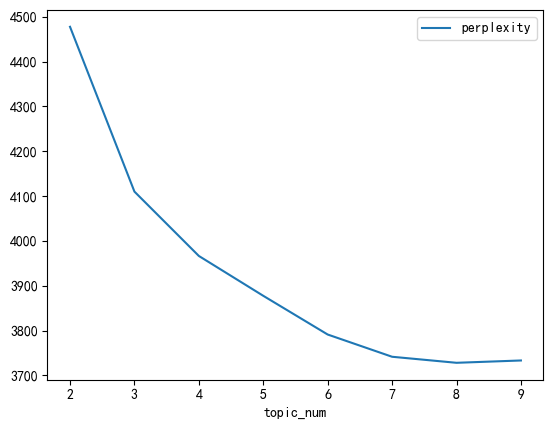

In [17]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

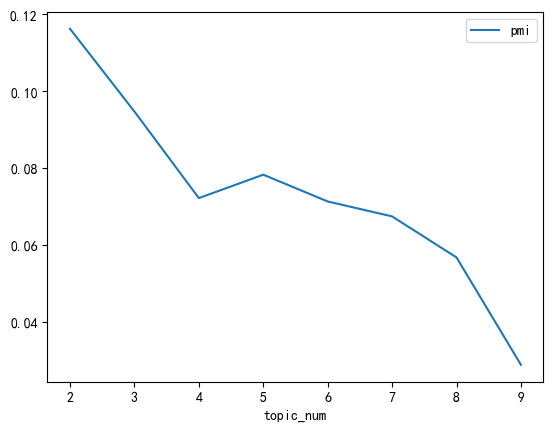

In [18]:
result.plot.line(x='topic_num', y='pmi')

### 視覺化呈現

-  為何選擇topic=5
    - 一開始未調整alpha及beta值時（alpha設auto, beta設0.2），pmi值為負數，因此我們開始嘗試調整alpha及beta值，一次只調整其中一個，調整後看perplexity及pmi有什麼變化，再繼續往該方向調整，alpha我們從0.8, 0.5及0.2慢慢遞減，最後調整到0.02時分類出來的主題獲得最佳的結果，此時beta是設置為0.1，因此我們最後選擇topic=5去做視覺畫呈現．

In [19]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 5,
    id2word=dictionary,
    random_state = 2048,
    alpha=0.02,
    eta=0.1,
    iterations=1000,
    passes=20 # 訓練次數
    )

2023-06-09 22:24:56,338 : INFO : using serial LDA version on this node
2023-06-09 22:24:56,344 : INFO : running online (multi-pass) LDA training, 5 topics, 20 passes over the supplied corpus of 2212 documents, updating model once every 2000 documents, evaluating perplexity every 2212 documents, iterating 1000x with a convergence threshold of 0.001000
2023-06-09 22:24:56,345 : INFO : PROGRESS: pass 0, at document #2000/2212
2023-06-09 22:25:02,873 : INFO : merging changes from 2000 documents into a model of 2212 documents
2023-06-09 22:25:02,877 : INFO : topic #0 (0.020): 0.019*"特斯拉" + 0.007*"充電" + 0.007*"駕駛" + 0.007*"問題" + 0.006*"電車" + 0.006*"電動車" + 0.005*"電池" + 0.005*"油車" + 0.004*"中國" + 0.003*"美國"
2023-06-09 22:25:02,878 : INFO : topic #1 (0.020): 0.016*"特斯拉" + 0.007*"充電" + 0.007*"駕駛" + 0.007*"問題" + 0.006*"煞車" + 0.006*"電車" + 0.005*"油車" + 0.004*"電池" + 0.004*"電動車" + 0.004*"美國"
2023-06-09 22:25:02,879 : INFO : topic #2 (0.020): 0.018*"電動車" + 0.010*"電車" + 0.010*"充電" + 0.008*"電池" + 0.008*"

In [20]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.102951 -0.050674       1        1  47.100865
2     -0.149953 -0.198162       2        1  28.994311
1     -0.157177  0.224457       3        1  11.003186
0      0.141611  0.048852       4        1   9.348851
3      0.268470 -0.024473       5        1   3.552787, topic_info=     Term          Freq         Total Category  logprob  loglift
419   特斯拉  10535.000000  10535.000000  Default  30.0000  30.0000
189    駕駛   2361.000000   2361.000000  Default  29.0000  29.0000
2148   里程   1747.000000   1747.000000  Default  28.0000  28.0000
3074   降價   1772.000000   1772.000000  Default  27.0000  27.0000
184   電動車   6368.000000   6368.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
1301   保固    150.403290    367.991960   Topic5  -5.1085   2.4427
3074   降價    280.419185   1772.289435   Topic5  -4.4855   1.4937
1002   價格    234.533564   1678.943092   Topic5  -4.6642   1.3691
626    新車    154.898444   1007.905099   Topic5  -5.0790   1.4646
16     便宜    162.022234   1841.970517   Topic5  -5.0341   0.9066

[415 rows x 6 columns], token_table=       Topic      Freq Term
term                       
10304      1  0.025061   一手
10304      5  0.971133   一手
1827       1  0.110662   三寶
1827       3  0.885300   三寶
1827       5  0.003074   三寶
...      ...       ...  ...
14473      4  0.988663   魚眼
5207       2  0.996541   鴻海
15022      5  0.970024   黑內
684        2  0.031203   鼻孔
684        4  0.967301   鼻孔

[884 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 1, 4])

In [21]:
pyLDAvis.save_html(p, "lda_zh.html")

### 主題分析
| 主題 | 關鍵字 | 主題議題 | 
| --- | --- | --- | 
| 1 | 特斯拉、電車、充電、問題、車位、超充、便宜 | 電動車常討論到的議題 | 
| 2 | 電動車、中國、市場、電池、環保、未來 | 全球電動車的發展及市場 | 
| 3 | 特斯拉、自駕、煞車、三寶、車禍、新聞 | 特斯拉相關的新聞 | 
| 4 | 後座、空間、油耗、內裝、外觀、預算 | 購車會考量的因素 | 
| 5 | 顏色、地區、型式、交易、原廠、里程、自用 | 車輛買賣相關資訊 | 

In [22]:
# 取得每筆發文的主題分佈
topics_doc = best_model.get_document_topics(corpus,minimum_probability=0)

# 把每筆發文的主題分佈存成list
probabilities = [ [entry[1] for entry in doc] for doc in topics_doc ]
print(probabilities[0:10])

# 找出probabilities最大的主題 存入 doc_list
doc_list = [np.argmax(t) for t in probabilities]
newDocList = []
for i in doc_list:
    x = i + 1
    newDocList.append(x)
# print(newDocList)

[[0.6447943, 0.026445286, 7.561192e-05, 7.561192e-05, 0.32860917], [8.344371e-05, 0.17126206, 0.82848763, 8.344371e-05, 8.344371e-05], [0.19695172, 0.42233467, 0.22024874, 7.920004e-05, 0.16038568], [0.35015407, 0.53997064, 0.00010484851, 0.00010484851, 0.10966563], [0.34303045, 0.00011914477, 0.65661216, 0.00011914477, 0.00011914477], [0.029863011, 0.00014192652, 0.96971124, 0.00014192652, 0.00014192652], [0.00012135534, 0.00012135534, 0.9500706, 0.04956533, 0.00012135534], [5.689833e-05, 5.689833e-05, 0.49658564, 5.689833e-05, 0.5032437], [0.5565964, 0.14653648, 9.319841e-05, 9.319841e-05, 0.2966807], [4.7135753e-05, 4.7135753e-05, 0.9910776, 0.008781003, 4.7135753e-05]]


In [23]:
topic_ptt = ptt.copy()

In [24]:
# 將結果放進 DataFrame 裡
topic_ptt['topic'] = newDocList

In [25]:
topic_ptt.head()

,system_id,artUrl,artDate,artCatagory,whole_content,words,topic
0,1,https://www.ptt.cc/bbs/car/M.1651362925.A.227....,2022-05-01 07:55:23,car,心得入手心得每個人心中都有一台屬於自己的本命車而我的本命車就是野馬雖然這台車操控很美式很差的...,"[心得, 入手, 心得, 每個, 心中, 屬於, 本命, 車而, 本命, 野馬, 這台車, ...",1
1,2,https://www.ptt.cc/bbs/car/M.1651380384.A.4D8....,2022-05-01 12:46:20,car,新聞涉嫌排放數據造假歐洲原文連結原文內容涉嫌排放數據造假歐洲被盯上自年福斯柴油門造假醜聞後這...,"[新聞, 涉嫌, 排放, 數據, 造假, 歐洲, 內容, 涉嫌, 排放, 數據, 造假, 歐...",3
2,3,https://www.ptt.cc/bbs/car/M.1651381465.A.3B6....,2022-05-01 13:04:23,car,新聞全新方向盤曝光酷似特斯拉矩形方向原文連結原文內容自動駕駛技術即將到來在此之前汽車方向盤也...,"[新聞, 方向盤, 曝光, 酷似, 特斯拉, 矩形, 方向, 內容, 自動, 駕駛, 技術,...",2
3,4,https://www.ptt.cc/bbs/car/M.1651386286.A.A50....,2022-05-01 14:24:44,car,心得新款心得補充一個我買前完全不知道可是現在愛不釋手的小功能雖小但使用頻率高就是方向燈的自動...,"[心得, 新款, 心得, 補充, 愛不釋手, 功能, 雖小, 頻率, 方向, 自動, 取消,...",2
4,5,https://www.ptt.cc/bbs/car/M.1651397368.A.F21....,2022-05-01 17:29:26,car,新聞大改款將發表經銷商曝這天亮相原文連結原文內容三立新聞網年月日生活中心顏敏翔報導德國車廠旗...,"[新聞, 改款將, 發表, 經銷商, 這天, 亮相, 內容, 三立, 新聞網, 年月日, 生...",3


#### 時間分佈

In [26]:
# 轉換時間格式
topic_ptt['artDate'] = pd.to_datetime(topic_ptt['artDate'])
topic_ptt["artDate"] = topic_ptt["artDate"].dt.date


In [27]:
topic_ptt.head()

,system_id,artUrl,artDate,artCatagory,whole_content,words,topic
0,1,https://www.ptt.cc/bbs/car/M.1651362925.A.227....,2022-05-01,car,心得入手心得每個人心中都有一台屬於自己的本命車而我的本命車就是野馬雖然這台車操控很美式很差的...,"[心得, 入手, 心得, 每個, 心中, 屬於, 本命, 車而, 本命, 野馬, 這台車, ...",1
1,2,https://www.ptt.cc/bbs/car/M.1651380384.A.4D8....,2022-05-01,car,新聞涉嫌排放數據造假歐洲原文連結原文內容涉嫌排放數據造假歐洲被盯上自年福斯柴油門造假醜聞後這...,"[新聞, 涉嫌, 排放, 數據, 造假, 歐洲, 內容, 涉嫌, 排放, 數據, 造假, 歐...",3
2,3,https://www.ptt.cc/bbs/car/M.1651381465.A.3B6....,2022-05-01,car,新聞全新方向盤曝光酷似特斯拉矩形方向原文連結原文內容自動駕駛技術即將到來在此之前汽車方向盤也...,"[新聞, 方向盤, 曝光, 酷似, 特斯拉, 矩形, 方向, 內容, 自動, 駕駛, 技術,...",2
3,4,https://www.ptt.cc/bbs/car/M.1651386286.A.A50....,2022-05-01,car,心得新款心得補充一個我買前完全不知道可是現在愛不釋手的小功能雖小但使用頻率高就是方向燈的自動...,"[心得, 新款, 心得, 補充, 愛不釋手, 功能, 雖小, 頻率, 方向, 自動, 取消,...",2
4,5,https://www.ptt.cc/bbs/car/M.1651397368.A.F21....,2022-05-01,car,新聞大改款將發表經銷商曝這天亮相原文連結原文內容三立新聞網年月日生活中心顏敏翔報導德國車廠旗...,"[新聞, 改款將, 發表, 經銷商, 這天, 亮相, 內容, 三立, 新聞網, 年月日, 生...",3


In [28]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':topic_ptt.groupby(['artDate','topic']).size()
})
date_topic = date_topic.reset_index()
date_topic = date_topic.groupby([date_topic['artDate'],'topic']).sum().reset_index()

In [29]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic1', 'topic2','topic3','topic4','topic5']
date_df

,artDate,topic1,topic2,topic3,topic4,topic5
0,2022-05-01,1.0,2.0,4.0,0.0,0.0
1,2022-05-02,0.0,0.0,0.0,1.0,1.0
2,2022-05-03,1.0,0.0,1.0,1.0,0.0
3,2022-05-04,1.0,0.0,0.0,0.0,1.0
4,2022-05-05,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...
380,2023-05-26,2.0,0.0,0.0,0.0,3.0
381,2023-05-27,0.0,0.0,0.0,1.0,1.0
382,2023-05-28,1.0,0.0,2.0,0.0,0.0
383,2023-05-29,0.0,2.0,2.0,2.0,3.0


In [30]:
pickDate_df = date_df.copy()
pickDate_df['total'] = pickDate_df.apply(lambda x: x['topic1']+x['topic2']+x['topic3']+x['topic4']+x['topic5'], axis=1)
pickDate_df.sort_values('total', ascending=False, inplace=True)
index = pickDate_df.head(1).index.values[0]
new_pickDate_df=date_df[index:index+7]
new_pickDate_df

,artDate,topic1,topic2,topic3,topic4,topic5
79,2022-07-22,0.0,7.0,1.0,2.0,17.0
80,2022-07-23,1.0,3.0,4.0,0.0,6.0
81,2022-07-24,1.0,2.0,1.0,2.0,1.0
82,2022-07-25,1.0,3.0,0.0,0.0,0.0
83,2022-07-26,1.0,3.0,0.0,2.0,2.0
84,2022-07-27,1.0,0.0,1.0,0.0,0.0
85,2022-07-29,0.0,1.0,1.0,0.0,1.0


- 2022/7/22 知名藝人林志穎駕駛特斯拉Model X失控自撞分隔島，導致車輛起火，燒成廢鐵，我們推測可能是因為這個新聞，導致當週的討論量提升，可以看到topic2及topic3的討論量都有所提升．

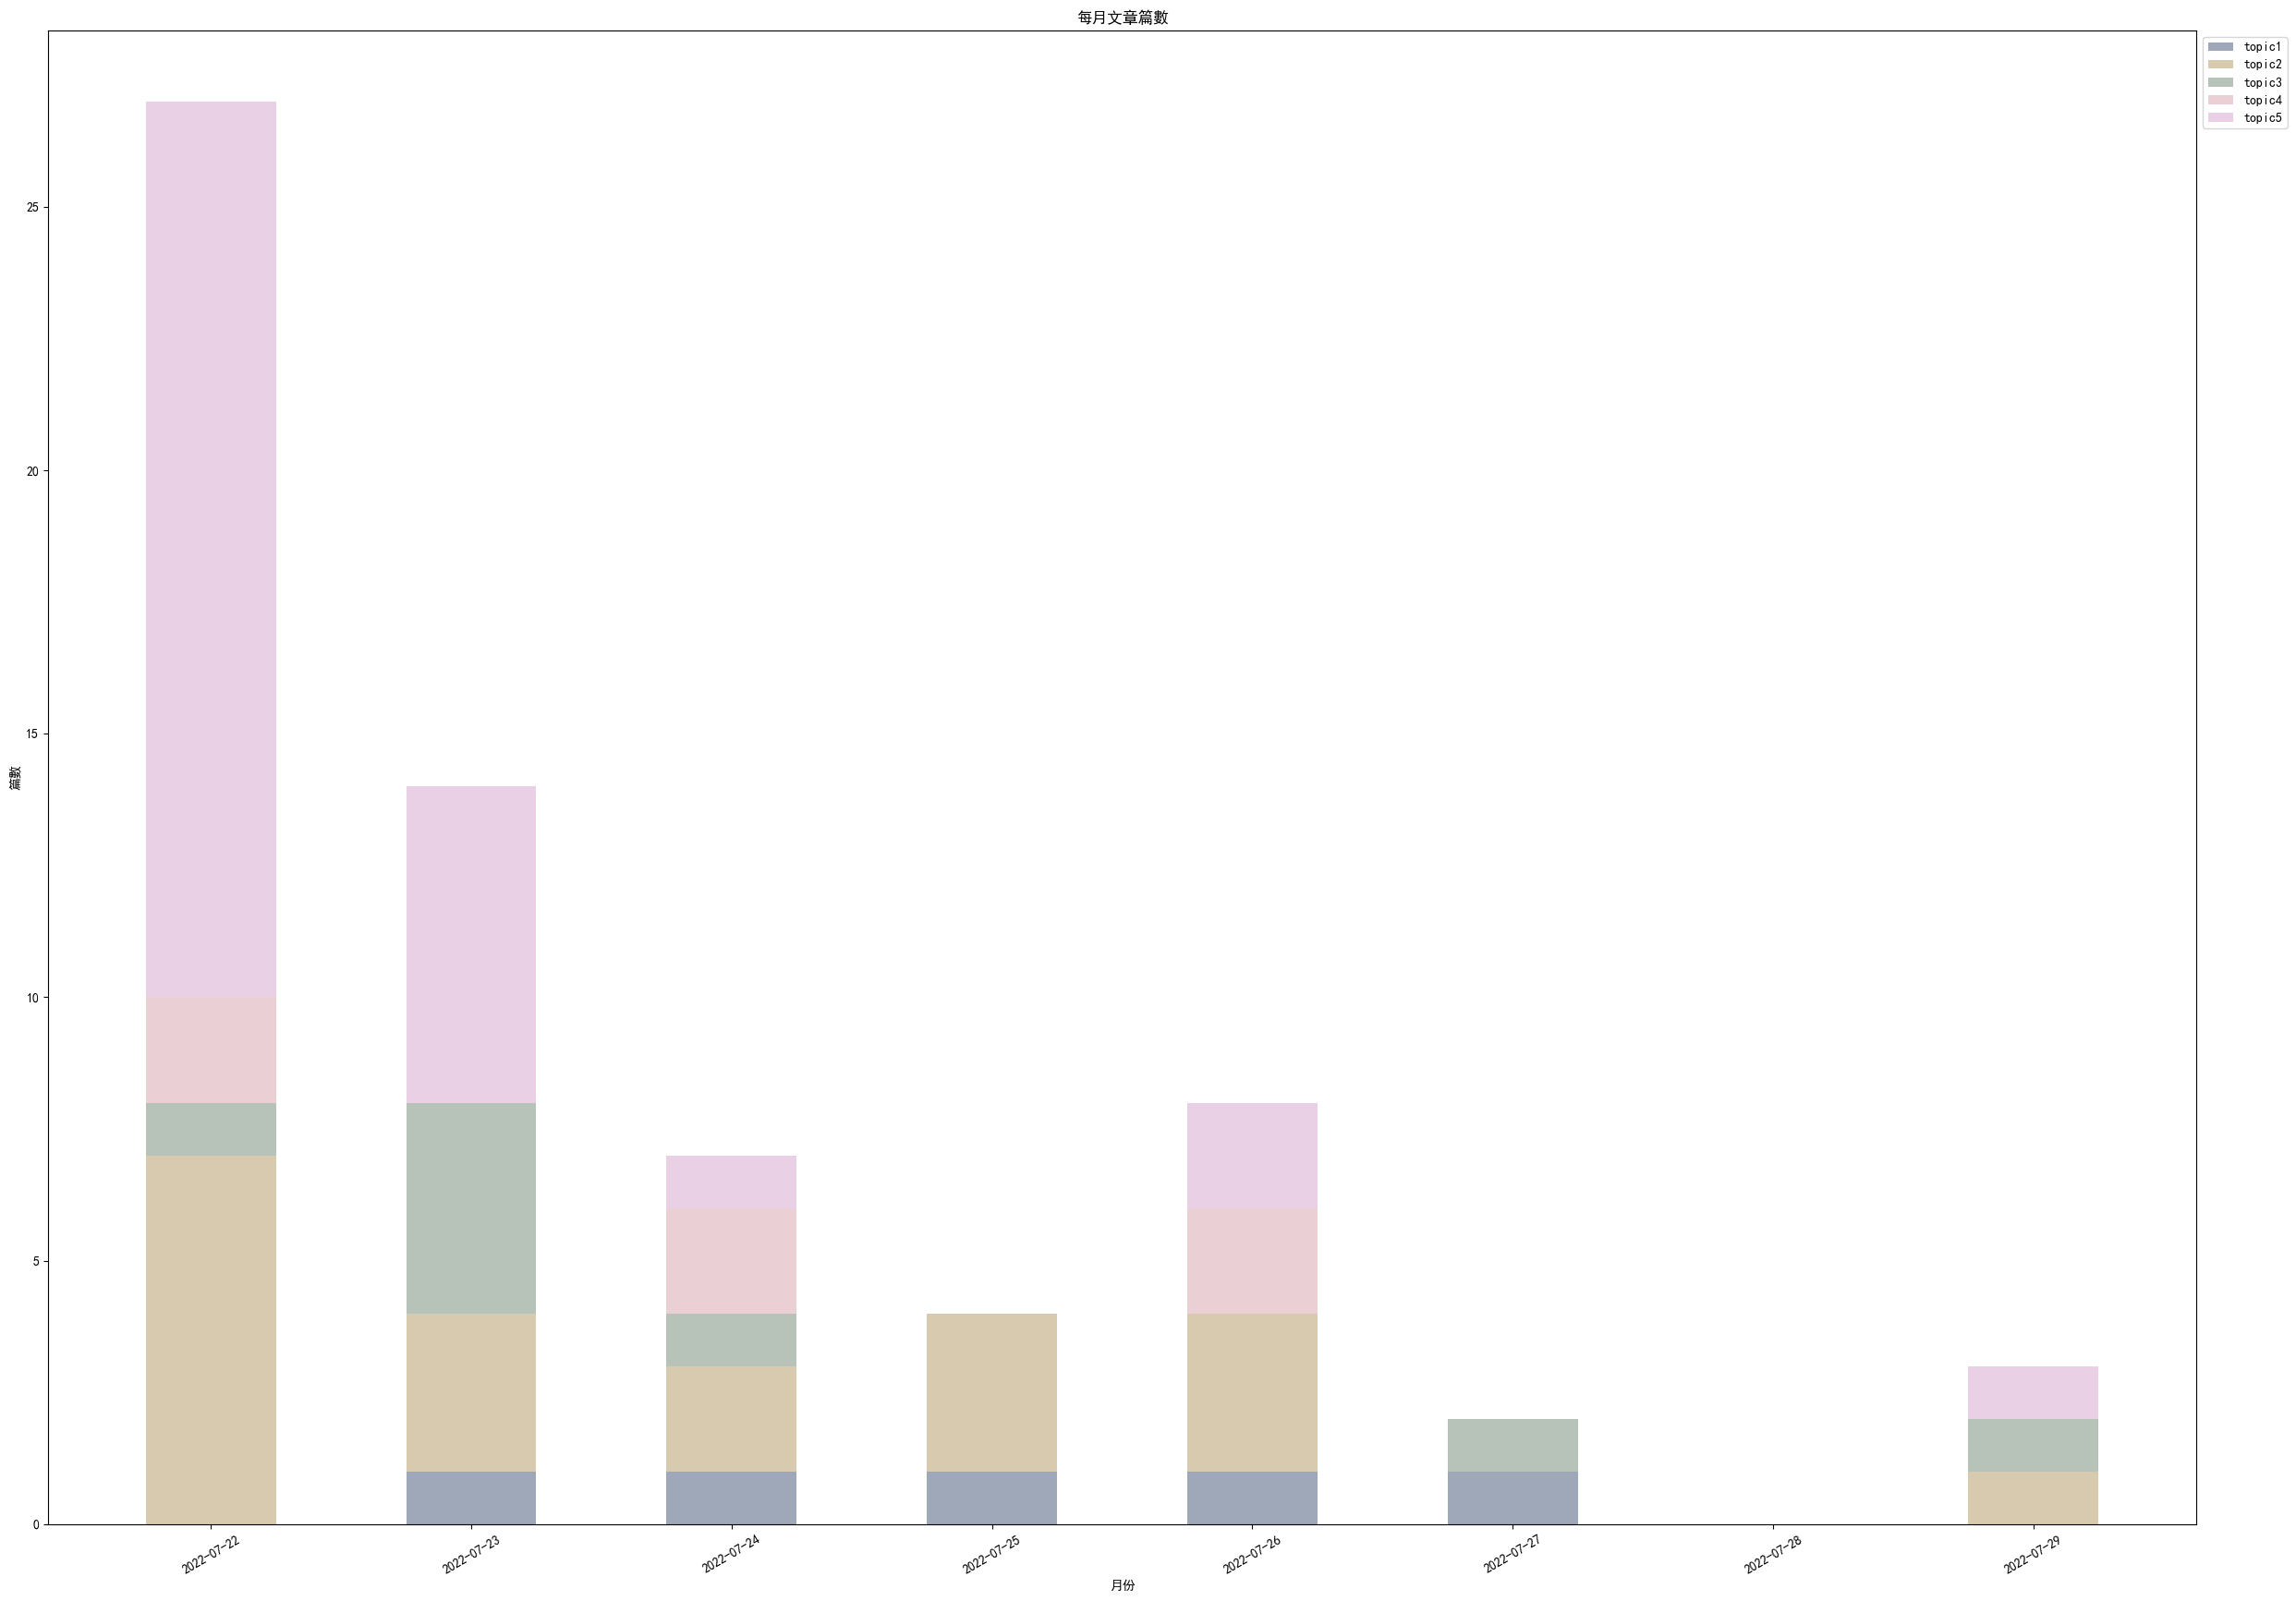

In [31]:
plt.subplots(figsize=(30, 21))
color = ["#9FA8B9", "#D8CAAF", "#B7C2B8", "#EAD0D5","#EAD0E5"]
column = ['topic1', 'topic2', 'topic3','topic4','topic5']
temp_bottom = 0

for i in range(0,5):
    if(i>0):
        temp_bottom = temp_bottom + new_pickDate_df[column[i-1]]
        plt.bar(new_pickDate_df.artDate, new_pickDate_df[column[i]] ,color=color[i], bottom=temp_bottom ,label=column[i] , width=0.5)
    else: # 主題一 bottom 為 0
        plt.bar(new_pickDate_df.artDate, new_pickDate_df[column[i]] ,color=color[i], label=column[i] , width=0.5)
        

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

## 6. 主題情緒分析

### 使用SnowNLP進行情緒分析

In [32]:
senti_ptt = topic_ptt.copy()

In [33]:
# 清除型態不符的資料
index_to_drop = senti_ptt[senti_ptt['whole_content'].apply(lambda x: isinstance(x, float))].index
senti_ptt = senti_ptt.drop(index_to_drop)

In [34]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

In [35]:
# 幫每篇文章加上情緒分數
senti_ptt['sentimentValue'] = senti_ptt.apply(lambda row : get_sentiment(row['whole_content'],) , axis=1)
senti_ptt.head()

,system_id,artUrl,artDate,artCatagory,whole_content,words,topic,sentimentValue
0,1,https://www.ptt.cc/bbs/car/M.1651362925.A.227....,2022-05-01,car,心得入手心得每個人心中都有一台屬於自己的本命車而我的本命車就是野馬雖然這台車操控很美式很差的...,"[心得, 入手, 心得, 每個, 心中, 屬於, 本命, 車而, 本命, 野馬, 這台車, ...",1,3.061966e-07
1,2,https://www.ptt.cc/bbs/car/M.1651380384.A.4D8....,2022-05-01,car,新聞涉嫌排放數據造假歐洲原文連結原文內容涉嫌排放數據造假歐洲被盯上自年福斯柴油門造假醜聞後這...,"[新聞, 涉嫌, 排放, 數據, 造假, 歐洲, 內容, 涉嫌, 排放, 數據, 造假, 歐...",3,0.000000e+00
2,3,https://www.ptt.cc/bbs/car/M.1651381465.A.3B6....,2022-05-01,car,新聞全新方向盤曝光酷似特斯拉矩形方向原文連結原文內容自動駕駛技術即將到來在此之前汽車方向盤也...,"[新聞, 方向盤, 曝光, 酷似, 特斯拉, 矩形, 方向, 內容, 自動, 駕駛, 技術,...",2,0.000000e+00
3,4,https://www.ptt.cc/bbs/car/M.1651386286.A.A50....,2022-05-01,car,心得新款心得補充一個我買前完全不知道可是現在愛不釋手的小功能雖小但使用頻率高就是方向燈的自動...,"[心得, 新款, 心得, 補充, 愛不釋手, 功能, 雖小, 頻率, 方向, 自動, 取消,...",2,0.000000e+00
4,5,https://www.ptt.cc/bbs/car/M.1651397368.A.F21....,2022-05-01,car,新聞大改款將發表經銷商曝這天亮相原文連結原文內容三立新聞網年月日生活中心顏敏翔報導德國車廠旗...,"[新聞, 改款將, 發表, 經銷商, 這天, 亮相, 內容, 三立, 新聞網, 年月日, 生...",3,0.000000e+00


### 針對5個主題個別進行分析

In [36]:
topic1_sentiment = senti_ptt[senti_ptt['topic']==1]  
topic2_sentiment = senti_ptt[senti_ptt['topic']==2] 
topic3_sentiment = senti_ptt[senti_ptt['topic']==3] 
topic4_sentiment = senti_ptt[senti_ptt['topic']==4] 
topic5_sentiment = senti_ptt[senti_ptt['topic']==5] 

Topic 1 : 電動車常討論到的議題

In [37]:
# 看一下情緒的分布
topic1_sentiment['sentimentValue'].describe()

count    1.470000e+02
mean     2.367683e-07
std      2.111980e-06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.482289e-05
Name: sentimentValue, dtype: float64

<Axes: >

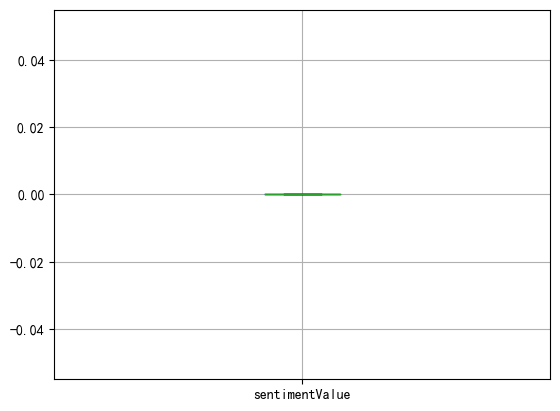

In [38]:
# 看一下情緒的分布
topic1_sentiment['sentimentValue'].describe()

# 情緒分布的盒狀圖
boxplot = topic1_sentiment.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

- 此圖可以看到此主題沒有什麼情緒，可見大家都很理性的討論有關特斯拉相關的議題，像是車位或充電等等

C:\Users\collin\AppData\Local\Temp\ipykernel_18028\713993082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic1_sentiment['artDate'] =  pd.to_datetime(topic1_sentiment['artDate']).dt.to_period('M')
C:\Users\collin\AppData\Local\Temp\ipykernel_18028\713993082.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


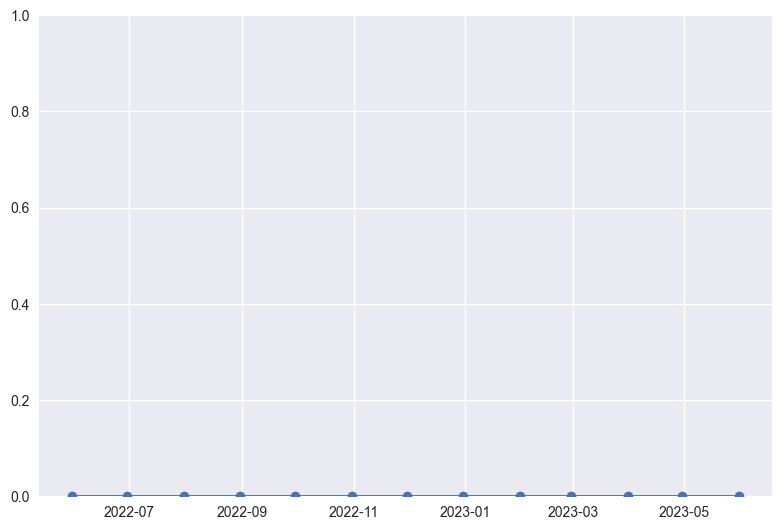

In [39]:
# 將每個月的情緒分數取平均
topic1_sentiment['artDate'] =  pd.to_datetime(topic1_sentiment['artDate']).dt.to_period('M')

sentiment_count = topic1_sentiment.groupby(['artDate'])['sentimentValue'].mean().reset_index()

# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

Topic 2 : 全球電動車的發展及市場

In [40]:
# 看一下情緒的分布
topic2_sentiment['sentimentValue'].describe()

count    2.290000e+02
mean     5.908369e-02
std      2.308005e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.134648e-13
max      1.000000e+00
Name: sentimentValue, dtype: float64

<Axes: >

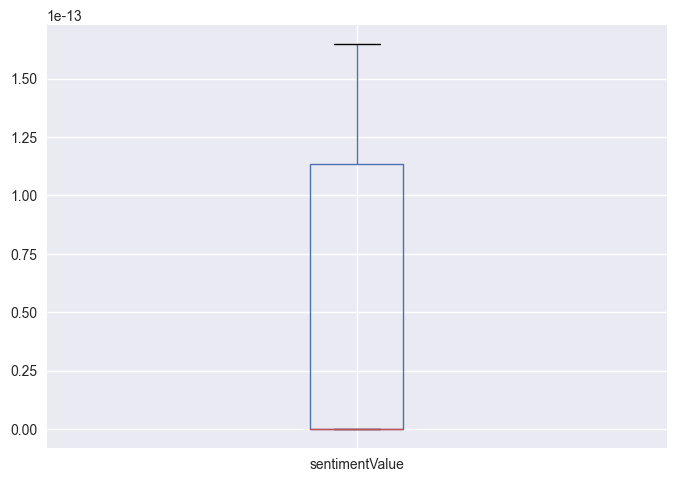

In [41]:
# 情緒分布的盒狀圖
boxplot = topic2_sentiment.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

- 這邊可以看到中位數是位於盒子的下半部分，表示情緒偏向於負向，可能是因為此主題探討的範圍有關電池及環保問題，而特斯拉的電池爆炸會產生有毒物質會污染環境，我們推測可能是因為此原因輿論的情緒才比較偏負向

C:\Users\collin\AppData\Local\Temp\ipykernel_18028\4212522119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic2_sentiment['artDate'] =  pd.to_datetime(topic2_sentiment['artDate']).dt.to_period('M')
C:\Users\collin\AppData\Local\Temp\ipykernel_18028\4212522119.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


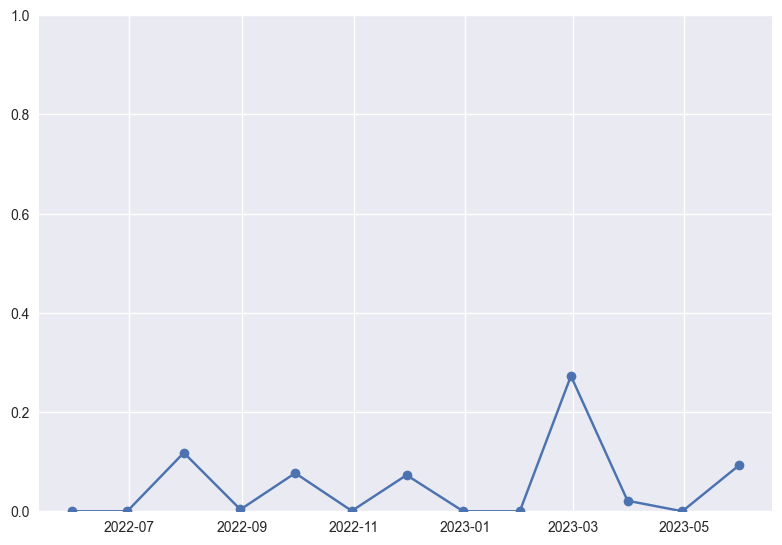

In [42]:
# 將每個月的情緒分數取平均
topic2_sentiment['artDate'] =  pd.to_datetime(topic2_sentiment['artDate']).dt.to_period('M')

sentiment_count = topic2_sentiment.groupby(['artDate'])['sentimentValue'].mean().reset_index()

# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

Topic 3 : 特斯拉相關的新聞

In [43]:
# 看一下情緒的分布
topic3_sentiment['sentimentValue'].describe()

count    6.220000e+02
mean     9.789485e-02
std      2.914617e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.082939e-11
max      1.000000e+00
Name: sentimentValue, dtype: float64

<Axes: >

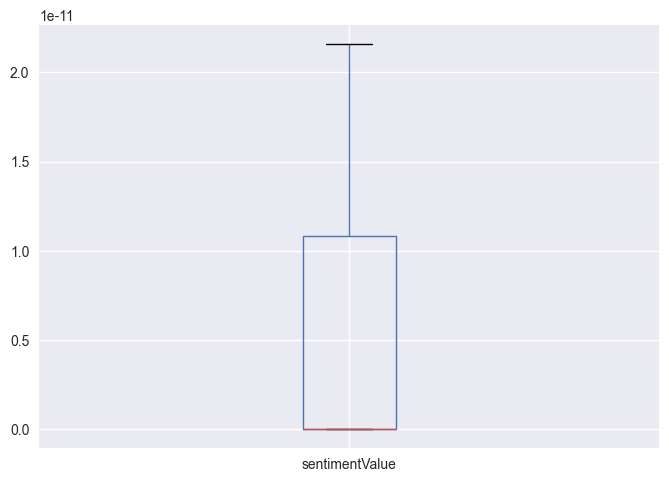

In [44]:
# 情緒分布的盒狀圖
boxplot = topic3_sentiment.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

- 這邊可以看到中位數是位於盒子的下半部分，表示情緒偏向於負向，我們推測偏負向可能是因為此主題比較偏特斯拉車禍自撞或駕駛室三寶的新聞，因此輿論的情緒可能會負面．

C:\Users\collin\AppData\Local\Temp\ipykernel_18028\120993594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic3_sentiment['artDate'] =  pd.to_datetime(topic3_sentiment['artDate']).dt.to_period('M')
C:\Users\collin\AppData\Local\Temp\ipykernel_18028\120993594.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


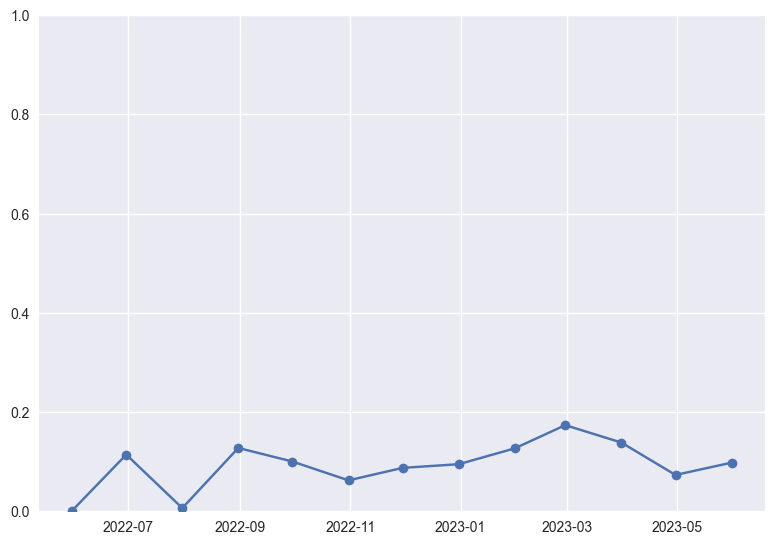

In [45]:
# 將每個月的情緒分數取平均
topic3_sentiment['artDate'] =  pd.to_datetime(topic3_sentiment['artDate']).dt.to_period('M')

sentiment_count = topic3_sentiment.groupby(['artDate'])['sentimentValue'].mean().reset_index()

# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

Topic 4 : 購車會考量的因素

In [46]:
# 看一下情緒的分布
topic4_sentiment['sentimentValue'].describe()

count    2.500000e+02
mean     4.974353e-02
std      1.953098e-01
min      0.000000e+00
25%      0.000000e+00
50%      2.213008e-12
75%      5.148000e-07
max      9.995214e-01
Name: sentimentValue, dtype: float64

<Axes: >

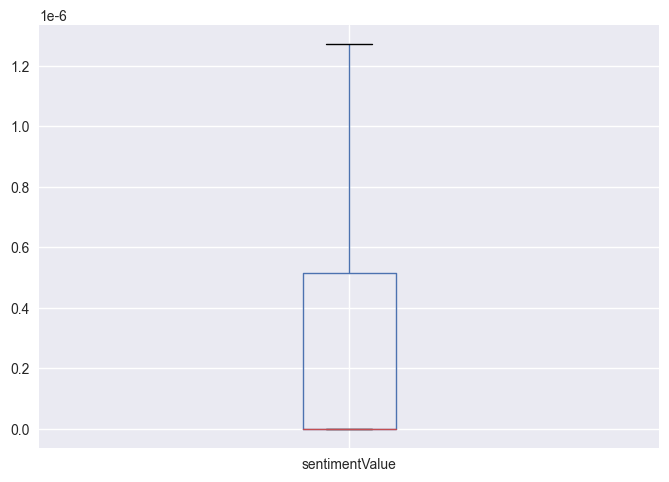

In [47]:
# 情緒分布的盒狀圖
boxplot = topic4_sentiment.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

- 這邊可以看到中位數是位於盒子的下半部分，表示情緒偏向於負向，推測可能是因為車子的買家想買的車子價格太高不符合預算，才造成較負面的情緒．

C:\Users\collin\AppData\Local\Temp\ipykernel_18028\4262786616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic4_sentiment['artDate'] =  pd.to_datetime(topic4_sentiment['artDate']).dt.to_period('M')
C:\Users\collin\AppData\Local\Temp\ipykernel_18028\4262786616.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


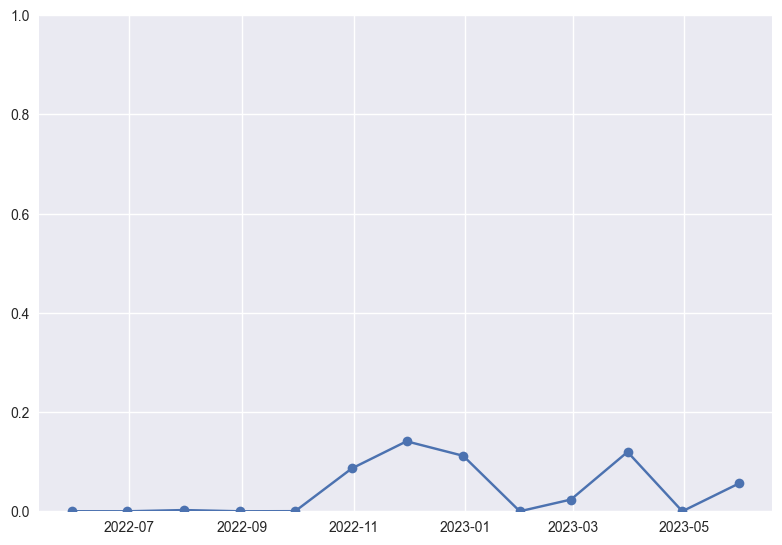

In [48]:
# 將每個月的情緒分數取平均
topic4_sentiment['artDate'] =  pd.to_datetime(topic4_sentiment['artDate']).dt.to_period('M')

sentiment_count = topic4_sentiment.groupby(['artDate'])['sentimentValue'].mean().reset_index()

# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

Topic 5 : 車輛買賣相關資訊

In [49]:
# 看一下情緒的分布
topic5_sentiment['sentimentValue'].describe()

count    963.000000
mean       0.018780
std        0.127228
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: sentimentValue, dtype: float64

<Axes: >

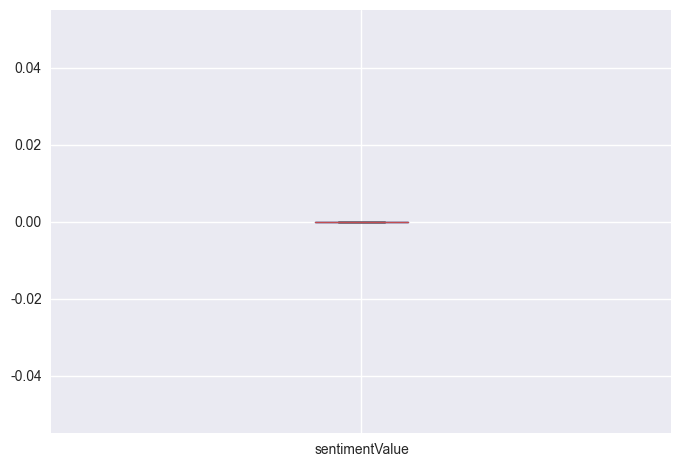

In [50]:
# 情緒分布的盒狀圖
boxplot = topic5_sentiment.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

- 圖中可以看到輿論對於此主題沒有什麼情緒起伏，可見輿論非常理性在討論電動車買賣的相關資訊

C:\Users\collin\AppData\Local\Temp\ipykernel_18028\4170597695.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic5_sentiment['artDate'] =  pd.to_datetime(topic5_sentiment['artDate']).dt.to_period('M')
C:\Users\collin\AppData\Local\Temp\ipykernel_18028\4170597695.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


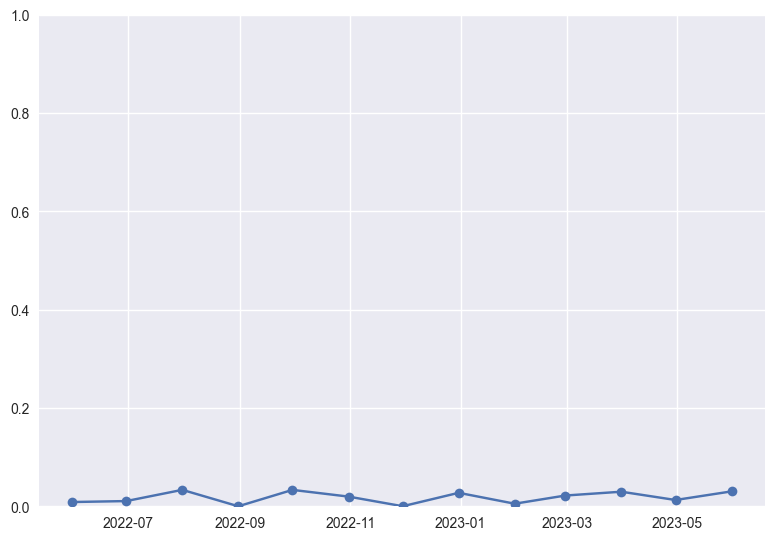

In [51]:
# 將每個月的情緒分數取平均
topic5_sentiment['artDate'] =  pd.to_datetime(topic5_sentiment['artDate']).dt.to_period('M')

sentiment_count = topic5_sentiment.groupby(['artDate'])['sentimentValue'].mean().reset_index()

# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

## 7. 結論

從我們上面做的主題探討及輿情分析，我們可以看出電動車大致有分成以上這5個主題，以及個主題輿論討論的情緒分佈．

#### 影片連結
<a href="https://youtu.be/cELzcZ8sFxQ">影片連結</a>